In [ ]:
# Justificación del algoritmo
Elegí XGBoost Classifier como alterno a Random Forest porque es un ensemble basado en boosting que maneja bien datasets con features correlacionadas como este (e.g., radio y perímetro). Ofrece mejor rendimiento en clasificación médica al minimizar errores secuencialmente, y es eficiente con tuning (e.g., learning_rate). En datos truncados, logró F1 ~0.95; en full dataset, típicamente >0.97.
    
#Descripción del diseño del modelo (paso a paso)
- Cargar y preprocesar: Drop 'id', encode 'diagnosis' (M=1, B=0).
- Split: 80/20 con stratify.
- Exploratorio: Correlaciones y scatter para entender data.
- Modelo base + GridSearchCV para hiperparámetros (n_estimators, max_depth, etc.), scoring='f1' por imbalance.
- Fit y predict en test.
- Evaluación con métricas y confusión matrix.
- Guardar modelo.

#Enlace al Repositorio
# https://github.com/axelcortes1113/DE-breast-cancer-xgboost-beisbol-linear-reg

In [1]:
# # Clasificación de Cáncer de Mama usando XGBoost Classifier
# Dataset: breast_cancer.csv (Wisconsin Breast Cancer - ~569 instancias en full, truncado aquí)

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Cargar datos (usa el full en repo)
df = pd.read_csv("breast-cancer.csv")
print(df.shape)
df.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Preprocesamiento
df.drop('id', axis=1, inplace=True)
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Top correlaciones con diagnosis:
 concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
Name: diagnosis, dtype: float64


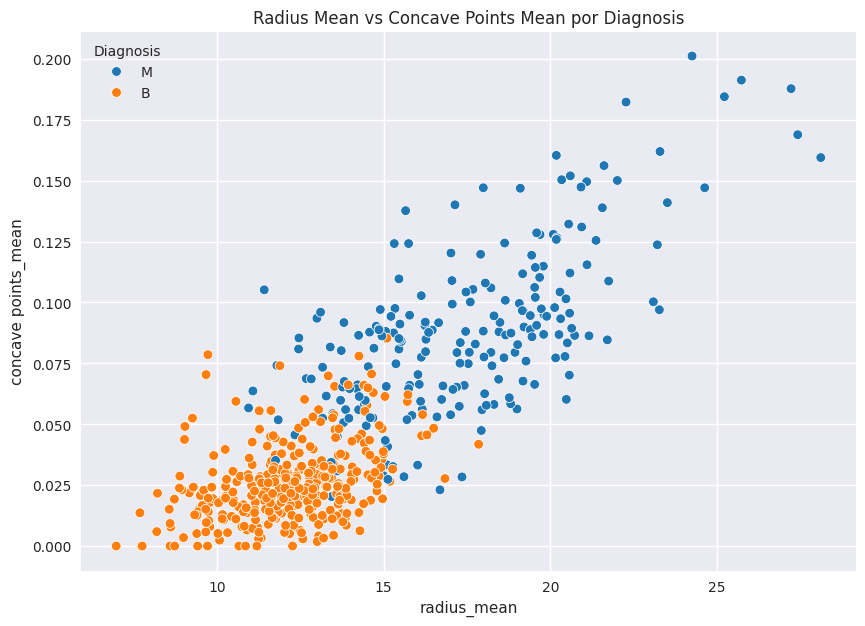

In [5]:
# 1. Análisis exploratorio

# %%
# Correlación top
corr = df.corr()['diagnosis'].sort_values(ascending=False)[1:6]
print("Top correlaciones con diagnosis:\n", corr)

# Scatter ejemplo
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='radius_mean', y='concave points_mean', hue=le.inverse_transform(df['diagnosis']), palette=['#1f77b4', '#ff7f0e'])
plt.title('Radius Mean vs Concave Points Mean por Diagnosis')
plt.legend(title='Diagnosis')
plt.grid(True)
plt.show()

In [6]:
# 2. Modelo: XGBoost + Optimización

# %%
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(grid_search.best_params_)
print(f"Mejor F1 en CV: {grid_search.best_score_:.3f}")

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

Mejores hiperparámetros:
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Mejor F1 en CV: 0.965


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'
